# Basic Statistics (Part 2)

**Prerequisite**

* $\texttt{numpy}$ and $\texttt{matplotlib}$.
* Basic Statistics (Part 1)

**New skills**

* Probability notation and basic rules
* Likelihood functions
* Fitting a model

In [1]:
# Let's start with importing our packages
import numpy as np
import scipy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# We can beautify our plots by changing the matplotlib settings a little
plt.rcParams['font.size'] = 18
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['font.family'] = "serif"

## Part 1: probability functions

We recently learned how to draw random numbers using $\texttt{python}$ from Gaussian and Poisson distributions. Let's briefly review those skills.

```{admonition} Exercise 1
Draw 100 random numbers from a Gaussian distribution (with $\sigma=1$ and $\mu=0$) and plot the numbers in a histogram. On the same plot, repeat this experiment with 1000 and 10000 random draws. For each histogram, set `bins=30`, `range=[-4,4]`, `density=False`.

Repeat your experiments on a second plot but now set `density=True`.

Be sure to label your plots.

**Bonus:** try using `for` loops
```

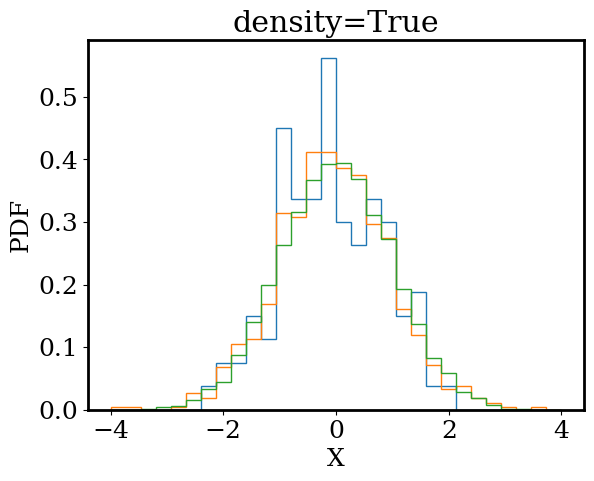

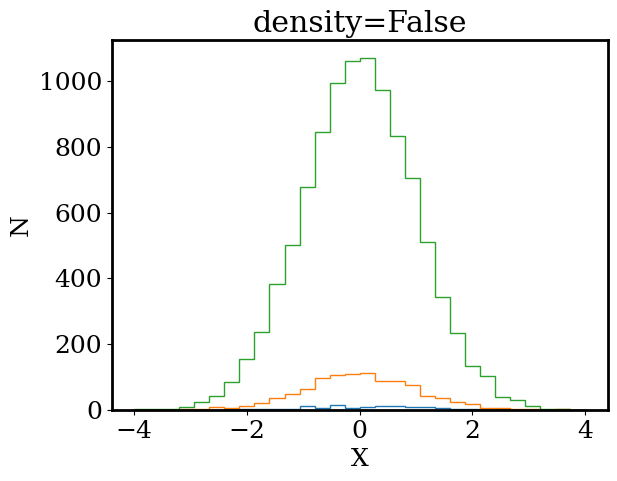

In [2]:
# parameters of our Gaussian distribution
mu = 0; sigma = 1

# plot the histogram
for density in [True,False]:

  for n in [100, 1000, 10000]:

    # draw random values using numpy
    rand = np.random.normal(loc = mu, scale = sigma, size = n)

    # plot the hist
    plt.hist(rand,density=density,bins=30,histtype='step',range=[-4,4])

  # it's always good practice to label the axes (even if it's a bit arbitrary in our case)
  _ = plt.xlabel('X')
  if density:
    _ = plt.ylabel('PDF')
  else:
    _ = plt.ylabel('N')
  _ = plt.title(f'density={density}')
  plt.show()

```{admonition} Exercise 2
Based on your plots, what does `density=True` and `density=False` do? What do you notice about the shape of the histogram as the number of random draws increases?
```

As we increase the number of random draws, we see the shape of our histograms appears to converge to a smooth bell shaped curve. If there was a mathematical function that described that shape, we would no longer need to draw random numbers to understand the Guassian distribution. Instead, we could ask our function what numbers are likely and what numbers are unlikely.

Fortunately, we know the function that describes the histogram of Gaussian random variables. It is called the Gaussian Probability Density Function (PDF):
$$p(x) = \frac{1}{\sqrt{2\pi} \sigma} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

```{admonition} Exercise 3
Write a function for the Gaussian pdf: `def gaussian_pdf(x, mu, sigma)` that returns `p(x)`. Then plot the Gaussian pdf for `-4 < x < 4` alongside a histogram of random draws from the Gaussian distribution (with `density=True`). Repeat this process for $\sigma = 0.5, 1.0$ (all with $\mu = 0$).

How many random draws do you need for the histogram to closely match `p(x)`? Does `p(x)` match the histogram if we instead set `density=False`?

**Bonus:** use for loops
```

In [3]:
def gaussian_pdf(x, mu, sigma):
    return np.exp( -np.power(x-mu,2) / (2*sigma**2) ) / np.sqrt(2*np.pi*sigma**2)

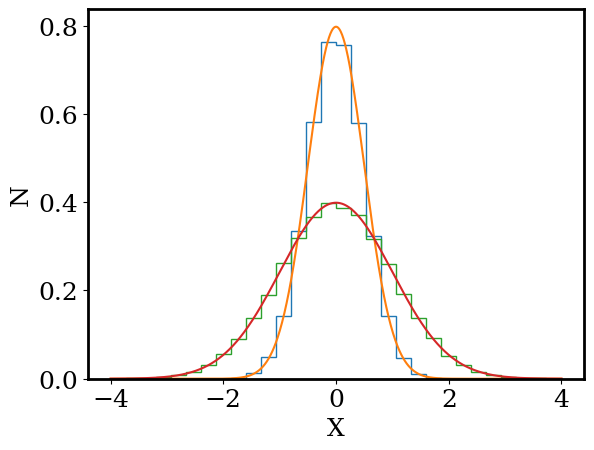

In [4]:
# parameters of our Gaussian distribution
mu = 0
n  = 100000

# plot the histogram
for sigma in [0.5,1]:

    # draw random values using numpy
    rand = np.random.normal(loc = mu, scale = sigma, size = n)

    # plot the hist
    plt.hist(rand,density=True,bins=30,histtype='step',range=[-4,4])

    # plot the pdf
    xp = np.linspace(-4,4, 1000)
    yp = gaussian_pdf(xp, mu, sigma)

    plt.plot(xp,yp)

# it's always good practice to label the axes (even if it's a bit arbitrary in our case)
_ = plt.xlabel('X')
if density:
  _ = plt.ylabel('PDF')
else:
  _ = plt.ylabel('N')

plt.show()

# Part 2: fitting models to data

## Linear fit

Let's revist the data on football players from earlier. We already saw that height and weight are correlated in the data (taller players tend to weight more). While we can clearly see the trend 'by eye,' is there a way to describe this correlation mathematically? For example, we may want to ask: "what is the typical weight of players who are 6 feet tall?"

In astronomy, we often find ourselves asking questions like that. For example, how does the size of a star depend on it's brightness? or how does the shape of a galaxy depend on its age?

In this section, we will learn how to find the mathemtical function that best describes a set of data.

Run the code below to load in the height and weights from the football player database.

In [ ]:
# Let's load in the data
import os
from google.colab import drive
from astropy.table import Table

drive.mount('/content/drive/')
os.chdir('/content/drive/Shareddrives/AST207/data')

cat = Table.read('./players_age.csv')

height = cat['height_inches']
weight = cat['weight']

height = np.array(height)
weight = np.array(weight)

The simplist relation between two variables `x` and `y` is the linear function:
$$ y = m * x + b $$
in our case, `x` is a player's height and `y` is the player's weight.

```{admonition} Exercise 4
Make the function `def linear(x,m,b)` that returns `y=m*x+b`. For `65 < x < 80` plot `linear(x, m, b)` alongside the observed heights and weights. Choose `m,b` such that the line best matches the observed data.

Be sure to include labels.
```

Text(0, 0.5, 'Weight [lbs]')

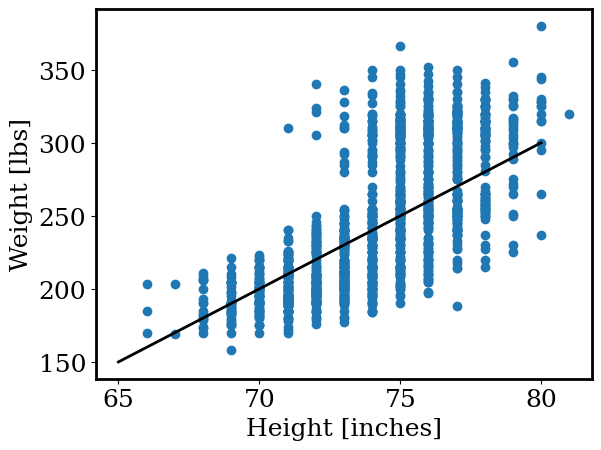

In [6]:
def linear(x,m,b):
  return m*x+b

m = 10
b = -500

xp = np.linspace(65, 80, 10 )
yp = linear(xp,m,b)

plt.scatter(height, weight)
plt.plot(xp, yp, color = 'k', linewidth=2)

plt.xlabel('Height [inches]')
plt.ylabel('Weight [lbs]')

Finding values of `m,b` (the slope and intercept of our linear function) by hand wasn't too difficult but we have a few problems:


1.   How do we convince our friends that we found the **best** values of `m,b`?
2.   What if we have a function with lots of variables? Then finding the best by hand is no longer feasible.

Thankfully, we don't have the find the best values by hand, we can ask our computers to help us. To have the computer find the best fitting line to the data, we'll follow a two step process:


1.   Define a function that tells us how well our line matches the data. Let's call this our *objective function*.
2.   Find the values of `m,b` that optimize our objective function.

The simplist objective function would be to calculate the difference between our model's prediction for a player's weight given their height and the player's actual weight. If we calculate the difference between the model and the data for all the players, we'll know how closely we match the data. Mathematically this looks like:

$$ \mathrm{Simple~Objective~Function}(m,b)  = | \mathrm{linear}(x_1,m,b) - y_1 | + | \mathrm{linear}(x_2,m,b) - y_2 | + \dots $$

the "$\dots$" means that we sum the difference between the model and the data for all the players in the table. The "| |" mean we are taking the absolute value (for example $| -1 |=1$).

This simple function is close but let's make two small changes:
1. Let's consider the **fractional** difference between the model prediction and the observed data (this will make sure we can fit data will small and large numbers easily).
2. Let's take the square of the difference instead of absolute value. This is a common convention and will help us later on in the class.

Now our final objective function is:

$$ \mathrm{Objective~Function}(m,b)  =  \frac{[ \mathrm{linear}(x_1,m,b) - y_1 )]^2}{|y_1|} + \frac{[ \mathrm{linear}(x_2,m,b) - y_2 )]^2}{|y_2|}  + \dots $$

(this objective function is commonly known as $\chi^2$)

```{admonition} Exercise 5
Write a function that calculates the "Objective Function" for a given set of `x` and `y` data and the two parameters `m,b` of the linear function. Your function should have the form: `def objective_function(x,y,m,b)`

As a test, `objective_function(x=height,y=weight,m=10,b=-500)` should return `6216.87`

Hint: use `np.abs` to take the absolute value
```

In [7]:
def objective_function(x,y,m,b):
  y_model = linear(x,m,b)

  return np.sum(np.power(y-y_model,2) / np.abs(y) )

In [8]:
objective_function(x=height,y=weight,m=10,b=-500)

6216.870738454954

```{admonition} Exercise 6
Use your `objective_function` to search for good values of `m,b`. Using `for` loops, calculate `objective_function` for $0<m<20$ and $-1000<b<0$. For each combination of `b,m` plot `b` vs. `m` on a scatter plot with the color set by `simple_objective_function(x,y,m,b)`. For an example of a scatter plot with the points colored by a third parameter, return to the `numpy_and_plotting.ipynb` notebook. Try 50 values of `b` and 50 values of `m` (it should run in less than a second). For ease of reading, plot `np.log10` of the objective function.
```

In [9]:
%%time
bs = []
ms = []
os = []
for b in np.linspace(-1000, 0, 50):
  for m in np.linspace(0, 20, 50):
      bs.append(b)
      ms.append(m)
      os.append( objective_function(x=height,y=weight,m=m,b=b) )

CPU times: user 309 ms, sys: 3.62 ms, total: 312 ms
Wall time: 492 ms


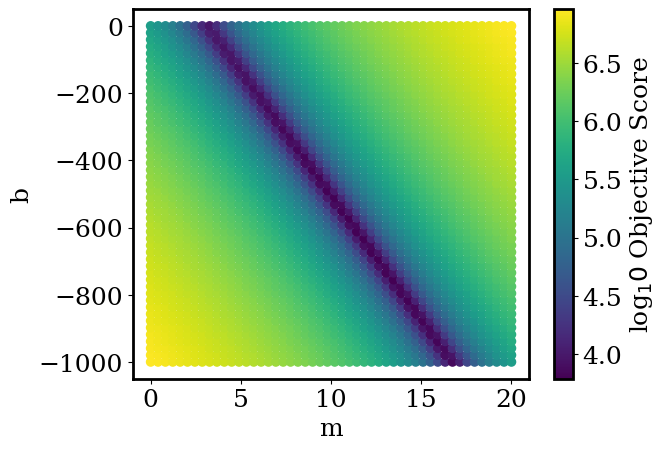

In [10]:
plt.scatter(ms, bs, c=np.log10(os), cmap='viridis')
plt.xlabel('m')
plt.ylabel('b')
plt.colorbar(label='log$_10$ Objective Score')
plt.show()

```{admonition} Exercise 7
From your grid search above, find the values of `m,b` that yield the lowest `simple_objective_function`. Plot the linear function using these parameters alongside the football data and your by-band linear function. Be sure to label your plot.

Hint: try using `np.argmin`
```

Text(0, 0.5, 'Weight [lbs]')

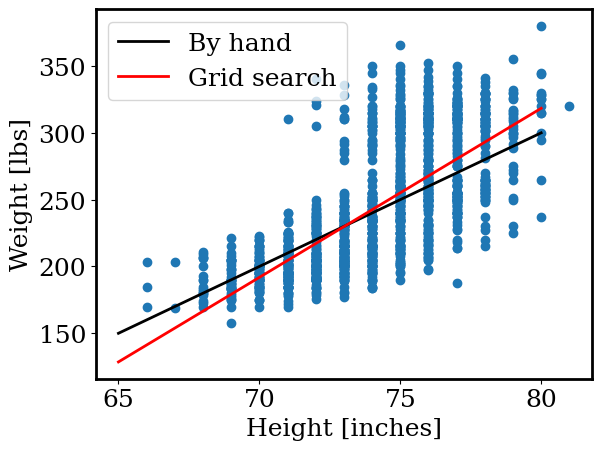

In [11]:
m = 10
b = -500

xp = np.linspace(65, 80, 10 )
yp = linear(xp,m,b)

plt.plot(xp, yp, color = 'k', linewidth=2,label='By hand')

plt.plot(xp, linear(xp, ms[np.argmin(os)], bs[np.argmin(os)]), color = 'r', linewidth=2, label='Grid search')

plt.scatter(height, weight)

plt.legend()

plt.xlabel('Height [inches]')
plt.ylabel('Weight [lbs]')

## Fitting astronomical data

Earlier, we looked at data from the Gaia space telescope. Gaia carefully observes the positions and properties of stars in our galaxy. The code below loads in the Gaia data for all stars within 15 parsec of the Sun.

In [12]:
# Let's load in the data
import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/Shareddrives/AST207/data')

# path to the table
path = 'gaia_15pc.csv'

# loading the table; this function assumes a 'comma separated file (aka csv)'
gaia = pd.read_csv(path)

# simple errors
gaia.loc[:,'color']     = gaia.gmag - gaia.rmag
gaia.loc[:,'color_err'] = 0.04
gaia.loc[:,'teff_err']  = 10. # K

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


```{admonition} Exercise 8
In a previous activity, we searched for which properties of a star are correlated (like how football players heights and weights are correlated). Let's revisit that activity here. Below, plot `teff` versus `color` for the Gaia data (`teff` is the temperature of the star and `color` is the difference between the stars' `g` and `r` magnitudes). Be sure to label your plot.
```

Text(0, 0.5, 'Color [mag.]')

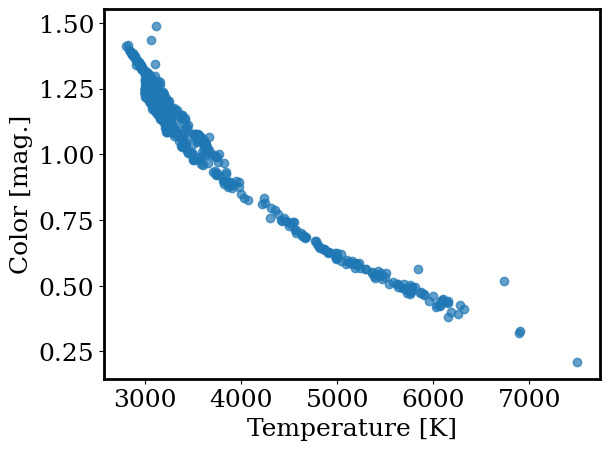

In [13]:
plt.scatter(gaia.teff,gaia.color,alpha=0.7)

plt.xlabel('Temperature [K]')
plt.ylabel('Color [mag.]')

Cool! We have a clear observational result: color and temperature of a star are strongly correlated.

However, we still don't know *how* color and temperature are related. Is the relation linear, quadratic, or perhaps much more complex? Answering this question will greatly increase our understanding of the stars in our catalog (it will also help our theorist friends try to *explain* what's happening here).

```{admonition} Exercise 9
Like we did for the football data, fit the `teff` and `color` data with a linear function. Use the "grid search" method we used for the football data. Try fitting the data by hand first to choose appropriate ranges of `m,b` to search.

Print out the best fit `m,b` and plot the best-fit line against the observed data.

Hint: the slope (`m`) will be small. Try `m = -1e-4` to start.
```

In [14]:
%%time
bs = []
ms = []
os = []
for b in np.linspace(0, 10, 50):
  for m in -10**np.linspace(-6, -3, 50):
      bs.append(b)
      ms.append(m)
      os.append( objective_function(x=gaia.teff,y=gaia.color,m=m,b=b) )

CPU times: user 2.27 s, sys: 77.3 ms, total: 2.35 s
Wall time: 2.79 s


In [15]:
ms[np.argmin(os)], bs[np.argmin(os)]

(-0.0002811768697974231, 2.0408163265306123)

Text(0, 0.5, 'Color [mag.]')

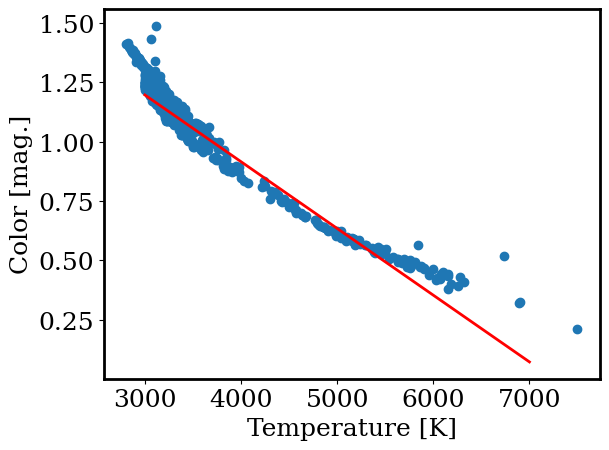

In [16]:

xp = np.linspace(3000, 7000, 10 )


plt.plot(xp, linear(xp, ms[np.argmin(os)], bs[np.argmin(os)]), color = 'r', linewidth=2, label='Grid search')
plt.scatter(gaia.teff, gaia.color)

plt.xlabel('Temperature [K]')
plt.ylabel('Color [mag.]')

We just fit a model to astronomical data! This is a critical tool in modern astronomy. But so far, we can only find the best solution by a time consuming "grid search." Let's find a better way.

Many algorithms have been developed to find the parameters that minimize a function (our grid search is one example). Let's use `scipy.optimize.minimize`.

```{admonition} Exercise 10
Run the code below to use `scipy.optimize.minimize`. Then plot the best fit linear function from `scipy.optimize.minimize` alongside the observed data and your "grid search" fit.
```

In [17]:
def general_objective_function(theta, fn, x, y):

  y_model = fn(x,*theta)

  return np.sum(np.power(y-y_model,2) / np.abs(y) )

out = scipy.optimize.minimize(general_objective_function, [-1e-4, 2], bounds = [[-1e-3,0], [0,10]], args = (linear, gaia.teff, gaia.color) )
m_fit, b_fit = out.x

Text(0, 0.5, 'Color [mag.]')

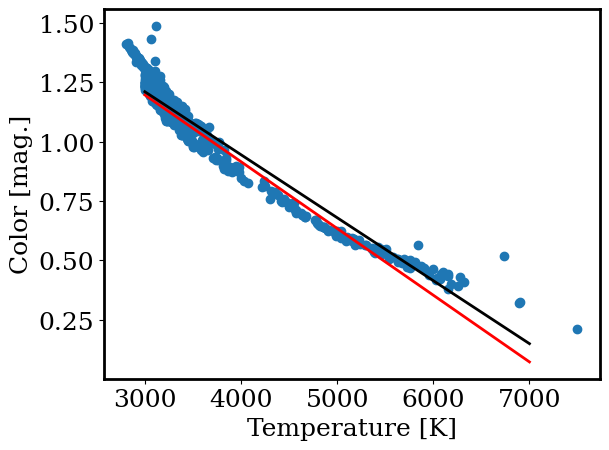

In [18]:
xp = np.linspace(3000, 7000, 10 )

plt.plot(xp, linear(xp, ms[np.argmin(os)], bs[np.argmin(os)]), color = 'r', linewidth=2, label='Grid search')
plt.plot(xp, linear(xp, m_fit, b_fit), color = 'k', linewidth=2, label='scipy')

plt.scatter(gaia.teff, gaia.color)

plt.xlabel('Temperature [K]')
plt.ylabel('Color [mag.]')

We can now perform a linear fit and even can do it quicky using `scipy`. However, the above plots show that a linear fit is not a great match to the data. So what is?

Fortunately, `general_objective_function` (which we provided for the activity above) allows us to change the function we are fitting...

```{admonition} Exercise 11
Let's try a model where color is *inversely* proportional to temperature:
$$ \mathrm{color} = m / T + b $$
Write a function `def inverse(x, m, b)` that returns the inverse function. Then use `scipy` to find the best fit parameters. Plot the best fit inverse function alongside the observed data and the best fit linear function.
```

In [19]:
def inverse(x, m, b):
  return m/x +b

out = scipy.optimize.minimize(general_objective_function,
                        x0=[5e3, 0.],
                        bounds = [(1e3,1e4),(-10,10)],
                        args=(inverse, gaia.teff, gaia.color) )

m_inv, b_inv = out.x

Text(0, 0.5, 'Color [mag.]')

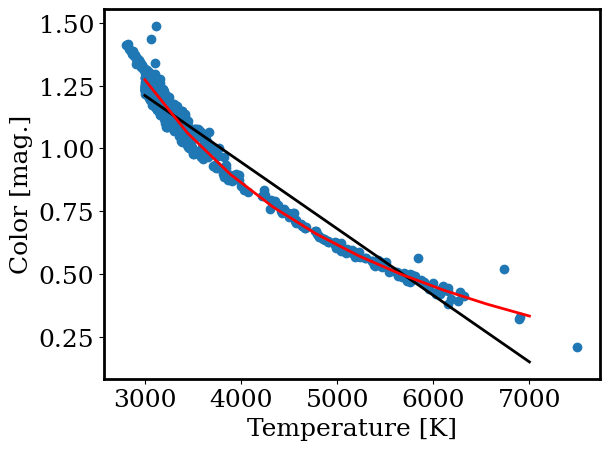

In [20]:
xp = np.linspace(3000, 7000, 10 )

plt.plot(xp, linear(xp, m_fit, b_fit), color = 'k', linewidth=2, label='linear')
plt.plot(xp, inverse(xp, m_inv, b_inv), color = 'r', linewidth=2, label='inverse')

plt.scatter(gaia.teff, gaia.color)

plt.xlabel('Temperature [K]')
plt.ylabel('Color [mag.]')